In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from datetime import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

from dataset import MetaDataset
from metadata.vcc import SanityMetadata

from models import save_model, load_model
from models.vae import ToyVAE
from maml import reptile_train

In [3]:
dataset = MetaDataset(SanityMetadata())
dataset.read_and_preprocess()
print('Data loaded', datetime.now())

Data loaded 2021-11-20 01:49:12.576260


In [4]:
device = torch.device('cpu')
model = ToyVAE()

# def criterion(recon_y, y, mu, log_var):
#     BCE = F.binary_cross_entropy(recon_y, y, reduction='sum')
#     # BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784),
#     #                              reduce=True, size_average=False)
#     print("BCE is:", BCE)
#     KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
#     print("KLD is:", KLD)
#     return BCE + KLD
#     # return BCE

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.0)


def train(trained_model, x, y, n_inner_loop=8):
    trained_model.train()
    x = torch.transpose(x, 0, 1)
    x = nn.functional.normalize(x)
#     x = x - torch.mean(x)
    y = torch.transpose(y, 0, 1)
    y = nn.functional.normalize(y)
#     y = y - torch.mean(y)
    x = x.to(device)
    y = y.to(device)
    for _ in range(n_inner_loop):
        optimizer.zero_grad()
        out_tuple = trained_model(x)
        out = out_tuple[0]
        mu = out_tuple[1]
        log_var = out_tuple[2]
#         loss = criterion(out, y, mu, log_var)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
    print(loss.item(), end='')

In [5]:
# Meta train

reptile_train(model, dataset, n_shot=None, n_iter_outer=100,
              outer_step_size=1e-1, inner_train_func=train)
save_model('saved_models/temp.pt', model)

Iter 0: 0.06315752863883972
Iter 1: 0.02725326269865036
Iter 2: 0.0075692604295909405
Iter 3: 0.0013587211724370718
Iter 4: 0.002128967549651861
Iter 5: 0.0026834337040781975
Iter 6: 0.0011797306360676885
Iter 7: 0.000985525781288743
Iter 8: 0.0010368353687226772
Iter 9: 0.0010205288417637348
Iter 10: 0.0010364331537857652
Iter 11: 0.0009556118748150766
Iter 12: 0.0011611825320869684
Iter 13: 0.0017294433200731874
Iter 14: 0.0013203279813751578
Iter 15: 0.0009696112247183919
Iter 16: 0.0008281355258077383
Iter 17: 0.0010041800560429692
Iter 18: 0.0009181846980936825
Iter 19: 0.0007849840330891311
Iter 20: 0.0006805965094827116
Iter 21: 0.0011511263437569141
Iter 22: 0.001015057903714478
Iter 23: 0.0010288850171491504
Iter 24: 0.0008799126953817904
Iter 25: 0.0007482207147404552
Iter 26: 0.0010155363706871867
Iter 27: 0.0009005552274174988
Iter 28: 0.0008089015609584749
Iter 29: 0.0008711996488273144
Iter 30: 0.0010562234092503786
Iter 31: 0.0007975735352374613
Iter 32: 0.00092797219986

In [6]:
# Second train after meta training

pretrained_model = load_model('saved_models/temp.pt', ToyVAE)


Source train


Target train


Source train aligned


Target train aligned


0.0006941288011148572

Test source


Test source


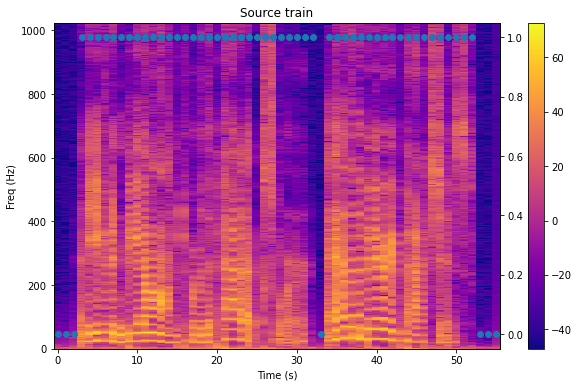

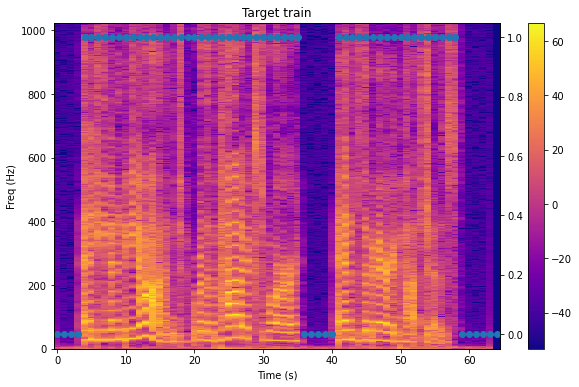

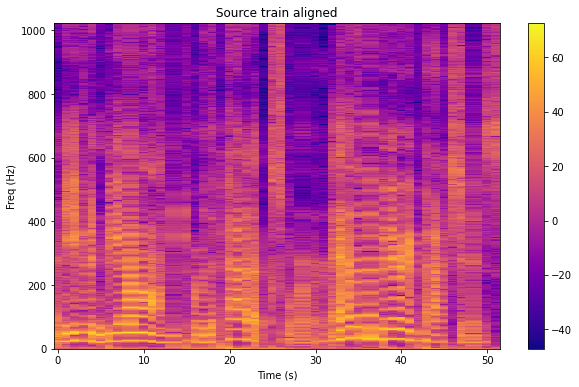

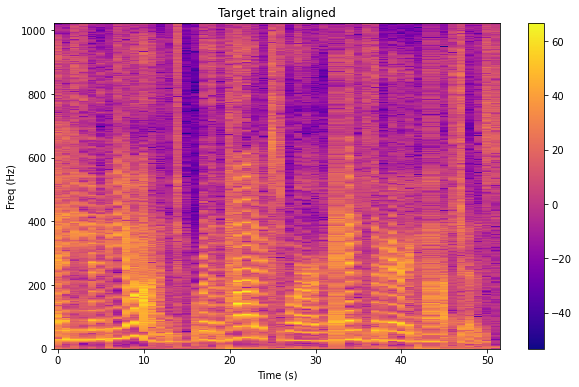

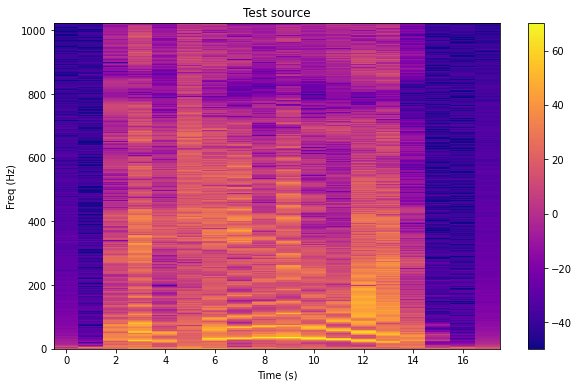

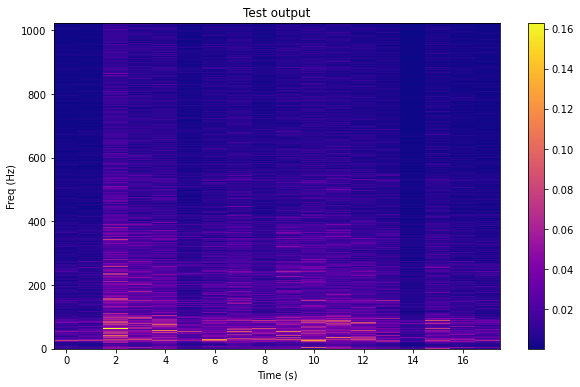

In [7]:
import numpy as np
import matplotlib.pyplot as plt

from env import sr
from transform import log_stft, db_to_amp
from dataset import read_audio, TaskDataset, InputData
from visualization import plot_spec
from vocoder import griffin_lim


def sound(x, rate=sr, label=''):
    from IPython.display import display, Audio, HTML
    display(HTML(
        '<style> table, th, td {border: 0px; }</style> <table><tr><td>'
        + label + '</td><td>' + Audio(x, rate=rate)._repr_html_()[3:]
        + '</td></tr></table>'
    ))


def test(c, train_source_filename, train_target_filename,
         test_input_filename):
    def plot_selected_frames(selected_frames):
        plt.twinx()
        plt.scatter(np.arange(selected_frames.size), selected_frames)

    task_dat = TaskDataset(train_source_filename, train_target_filename)
    input_dat = InputData(test_input_filename)
    plot_spec(log_stft(task_dat.source.amp), title='Source train')
    plot_selected_frames(task_dat.source.selected_frames)
    sound(read_audio(train_source_filename), label='Source train')
    plot_spec(log_stft(task_dat.target.amp), title='Target train')
    plot_selected_frames(task_dat.target.selected_frames)
    sound(read_audio(train_target_filename), label='Target train')

    train_x, train_y = task_dat.get()
    plot_spec(train_x, title='Source train aligned')
    sound(griffin_lim(db_to_amp(train_x)), label='Source train aligned')

    plot_spec(train_y, title='Target train aligned')
    sound(griffin_lim(db_to_amp(train_y)), label='Target train aligned')

    train_x, train_y = torch.from_numpy(train_x), torch.from_numpy(train_y)
    train(model, train_x, train_y, n_inner_loop=20)

    x = input_dat.get()
    x = torch.from_numpy(x.T)
    x = nn.functional.normalize(x)
    estimated_tuple = model(x)
    estimated = estimated_tuple[0]
    y = estimated.detach().numpy().T
    plot_spec(log_stft(input_dat.dat.amp), title='Test source')
    sound(read_audio(test_input_filename), label='Test source')
    plot_spec(y, title='Test output')
    sound(griffin_lim(db_to_amp(y)), label='Test source')


meta_dat = SanityMetadata()

test(pretrained_model, meta_dat.get(0, 0), meta_dat.get(1, 0),
     meta_dat.get(0, 1))

In [8]:
# test with actual samples
